In [1]:
!pip install datasets

-----------------
# **Libraries**

In [2]:
import os
from tokenizers import Tokenizer, pre_tokenizers, trainers, models
from datasets import load_dataset

-------------
# **Data Samples**

In [3]:
data = load_dataset("thainq107/iwslt2015-en-vi")

README.md:   0%|          | 0.00/522 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/133317 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1268 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1268 [00:00<?, ? examples/s]

In [4]:
data

DatasetDict({
    train: Dataset({
        features: ['en', 'vi'],
        num_rows: 133317
    })
    validation: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
    test: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
})

In [5]:
print(f"This is the data type of English Data: {type(data['train']['en'])}")
print(f"Length of Englosh train Dataset: {len(data['train']['en'])}")
print(f"Samples Sentence: {data['train']['en'][0]}")

print("-"*59)

print(f"This is the data type of Vietnamese Data: {type(data['train']['vi'])}")
print(f"Length of Vietnamese train Dataset: {len(data['train']['vi'])}")
print(f"Samples Sentence: {data['train']['vi'][0]}")

This is the data type of English Data: <class 'list'>
Length of Englosh train Dataset: 133317
Samples Sentence: Rachel Pike : The science behind a climate headline
-----------------------------------------------------------
This is the data type of Vietnamese Data: <class 'list'>
Length of Vietnamese train Dataset: 133317
Samples Sentence: Khoa học đằng sau một tiêu đề về khí hậu


-------------
# **Build Tokenizers**

In [6]:
# Init Tokenizers for English and Vietnamese
tokenizer_en = Tokenizer(models.WordLevel(unk_token = "<unk>"))
tokenizer_vi = Tokenizer(models.WordLevel(unk_token = "<unk>"))

tokenizer_en.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer_vi.pre_tokenizer = pre_tokenizers.Whitespace()

In [7]:
trainer = trainers.WordLevelTrainer(
    vocab_size = 15000,
    mn_frequency = 2,
    special_tokens = ["<pad>", "<unk>", "<bos>", "<eos>"] # Begin of Sentence = bos
)

# Train Tokenizers
tokenizer_en.train_from_iterator(data["train"]["en"], trainer)
tokenizer_vi.train_from_iterator(data["train"]["vi"], trainer)

# Save Trained Tokenizers
tokenizer_en.save("tokenizer_en.json")
tokenizer_vi.save("tokenizer_vi.json")

-------------
# **Data Preprocessing**

In [8]:
from transformers import PreTrainedTokenizerFast
seq_len = 75

# Load Tokenizers
tokenizer_en = PreTrainedTokenizerFast(
    tokenizer_file = "tokenizer_en.json",
    unk_token = "<unk>", pad_token = '<pad>', bos_token = "<bos>",
    eos_token = "<eos>"
)

tokenizer_vi = PreTrainedTokenizerFast(
    tokenizer_file = "tokenizer_vi.json",
    unk_token = "<unk>", pad_token = '<pad>', bos_token = "<bos>",
    eos_token = "<eos>"
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
def data_preprocessing(data):
    """
        We translate English Sentences -> Vietnamese
            -> Input = English
            -> Target/Label = Vietnamese
    """
    ipt = data['en']
    label = []
    for sentence in data['vi']:
        
        # Full Sentence = <bos> <Sentence> <eos>
        full = "<bos>" + sentence + "<eos>"
        label.append(full)

    ipt_tokenized = tokenizer_en(
        ipt, padding = "max_length", truncation = True, max_length = seq_len
    )

    label_tokenized = tokenizer_en(
        label, padding = "max_length", truncation = True, max_length = seq_len
    )

    # Return applicable format for HuggingFace Trainers
    return{
        "input_ids": ipt_tokenized['input_ids'],
        "labels": label_tokenized['input_ids']
    }

pp_data = data.map(data_preprocessing, batched=True)

Map:   0%|          | 0/133317 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

------
# **Models**

In [10]:
import torch
import torch.nn as nn
from transformers import PreTrainedModel, PretrainedConfig

class Seq2SeqRNNConfig(PretrainedConfig):
    def __init__(self, vocab_size_ipt = 10000, vocab_size_label = 10000,
                embed_dim = 128, hidden_dim = 128, dropout_p = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size_ipt = vocab_size_ipt
        self.vocab_size_label = vocab_size_label
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout_p

class EncoderRNN(nn.Module):
    def __init__(self, inpt_size, embed_dim, hidden_dim, dropout_p):
        super(EncoderRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inpt_size = inpt_size
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(inpt_size, self.embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first = True)
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, x):
        x = self.embedding(x) # batch_size x seq_len x embed_dim
        x = self.dropout(x)
        
        out, hidden = self.gru(x) 
        # Each out size: batch_size x seq_len x embed_dim
        # Each hidden (state) size: batch_size x embed_dim
        
        return out, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_dim, embed_dim, out_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(out_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, out_size) # Probability for every word in vocab

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.gru(x, hidden)
        out = self.fc(out) # batch_size x 1 x vocab_size
        return out, hidden

class Seq2SeqRNNModel(PreTrainedModel):
    config_class = Seq2SeqRNNConfig

    def __init__(self, config, tokenizer_en):
        super().__init__(config)
        self.encoder = EncoderRNN(
            config.vocab_size_ipt, config.embed_dim,
            config.hidden_dim, config.dropout
        )
        self.decoder = DecoderRNN(
            config.hidden_dim, config.embed_dim, config.vocab_size_ipt
        )
        self.BOS_IDX = tokenizer_en.bos_token_id
        self.loss_fn = nn.CrossEntropyLoss(ignore_index = 0) # Ignore <PAD>

    def forward(self, input_ids, labels):
        
        batch_size, seq_len = labels.shape
        
        decoder_input = torch.full(
            (batch_size, 1), self.BOS_IDX, dtype=torch.long
        ).to(input_ids.device)
        
        encoder_output, decoder_hidden = self.encoder(input_ids)
        decoder_outputs = []

        for i in range(seq_len):
            """
                Teacher Forcing so we take last hidden state of Encoder/GRU
                the Last Hidden State from Encoder acts as h_0

                NOT using the word WE PREDICTED
                we USED the word FROM THE LABEL + Past Hidden State (From input and from the words before)
                To predict the CURRENT word.

            I.e:
            I go to School
            => Go through Encoder
            => Take <eos> token 
            => Input <eos> token as h_0 for decoder

            Decoder: Tôi đi đến trường
            We use "Tôi" and h_0 to predict "đi"
            We then compute the loss from the predicted word (output of decoder) with the Label word
            We then use the label word "đi" as "context" to predict "đến" 
            we ONLY do this for TRAINING, at inference, we just take the last predicted word as input
            """
            decoder_output, decoder_hidden = self.decoder(decoder_input, 
                                                          decoder_hidden)
            decoder_outputs.append(decoder_output)
            # Take word at i index
            decoder_input = labels[:, i].unsqueeze(1)
            
        logits = torch.cat(decoder_outputs, dim=1) # batch_size x seq_len x vocab_size
        loss = self.loss_fn(logits.view(
            -1, logits.shape[-1]
        ), labels.view(-1))
        
        return{
            "loss": loss, "logits": logits
        }

config = Seq2SeqRNNConfig(
    vocab_size_ipt = len(tokenizer_en), vocab_size_label = len(tokenizer_vi)
)
model = Seq2SeqRNNModel(config, tokenizer_en)

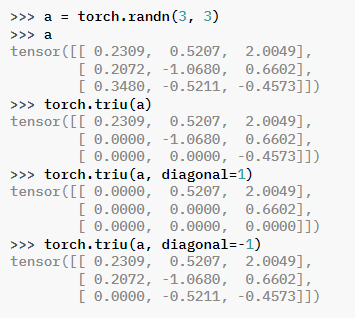

In [11]:
"""
Basically masking, diagnol = 1 
=> Diagnol at index 0
=> Everything above diagnol index 0 is retained 
(Diagnol with index 1 contains [0,0], [1,1], [2, 2])
"""

'\nBasically masking, diagnol = 1 \n=> Diagnol at index 0\n=> Everything above diagnol index 0 is retained \n(Diagnol with index 1 contains [0,0], [1,1], [2, 2])\n'

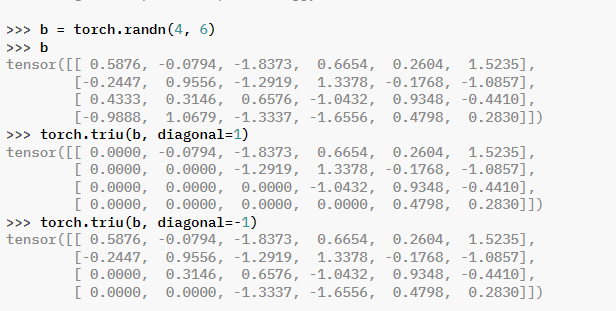

In [58]:

import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_square_subsequent_mask(sz, device):
    mask = (
        torch.triu(torch.ones((sz, sz), device=device)) == 1
    ).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(ipt, label):
    ipt_seq_len = ipt.shape[1]
    label_seq_len = label.shape[1]
    device = ipt.device  # Ensure device consistency

    ipt_mask = generate_square_subsequent_mask(ipt_seq_len, device).to(torch.bool)
    label_mask = torch.zeros((label_seq_len, label_seq_len), device=device).type(torch.bool)

    # Move padding masks to the same device
    ipt_padding_mask = (ipt == 0).to(device)
    label_padding_mask = (label == 0).to(device)

    return ipt_mask, label_mask, ipt_padding_mask, label_padding_mask

class Seq2SeqTransformerConfig(PretrainedConfig):
    def __init__(self,
                 vocab_size_ipt=10000, vocab_size_label=10000,
                 max_seq_length=50,
                 d_model=256, num_heads=8, num_layers=6, 
                 dropout_p=0.1, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size_ipt = vocab_size_ipt
        self.vocab_size_label = vocab_size_label
        self.max_seq = max_seq_length
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout_p

class Seq2SeqTransformerModel(PreTrainedModel):
    config_class = Seq2SeqTransformerConfig

    def __init__(self, config):
        super().__init__(config)

        # Move everything to the correct device
        self.embedding_ipt = nn.Embedding(config.vocab_size_ipt, config.d_model).to(device)
        self.embedding_lb = nn.Embedding(config.vocab_size_label, config.d_model).to(device)

        self.pos_embed_ipt = nn.Embedding(config.max_seq, config.d_model).to(device)
        self.pos_embed_lb = nn.Embedding(config.max_seq, config.d_model).to(device)

        self.transformer = nn.Transformer(
            d_model=config.d_model,
            nhead=config.num_heads,
            num_encoder_layers=config.num_layers,
            num_decoder_layers=config.num_layers,
            dropout=config.dropout,
            batch_first=True
        ).to(device)

        self.fc = nn.Linear(config.d_model, config.vocab_size_label).to(device)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Ignore <pad>

    def forward(self, input_ids, labels):
        label_input = labels[:, :-1]
        label_output = labels[:, 1:]
        batch_size, seq_len_ipt = input_ids.shape
        _, seq_len_label = label_input.shape

        ipt_pos = torch.arange(seq_len_ipt, device=input_ids.device).unsqueeze(0)
        label_pos = torch.arange(seq_len_label, device=labels.device).unsqueeze(0)

        ipt_embed = self.embedding_ipt(input_ids) + self.pos_embed_ipt(ipt_pos)
        label_embed = self.embedding_lb(label_input) + self.pos_embed_lb(label_pos)

        ipt_mask, label_mask, ipt_key_padding_mask, label_key_padding_mask = create_mask(
            input_ids, label_input
        )

        outs = self.transformer(
            ipt_embed, label_embed, ipt_mask, label_mask,
            src_key_padding_mask=ipt_key_padding_mask,
            tgt_key_padding_mask=label_key_padding_mask,
        )

        logits = self.fc(outs)
        loss = self.loss_fn(
            logits.permute(0, 2, 1), label_output
        )

        return {
            "loss": loss, "logits": logits
        }

    def encode(self, ipt, ipt_mask):
        _, seq_len_ipt = ipt.shape
        ipt_pos = torch.arange(seq_len_ipt, device=ipt.device).unsqueeze(0)

        # Ensure embeddings are on the correct device
        self.embedding_ipt = self.embedding_ipt.to(ipt.device)
        self.pos_embed_ipt = self.pos_embed_ipt.to(ipt.device)

        ipt_embed = self.embedding_ipt(ipt) + self.pos_embed_ipt(ipt_pos)
        return self.transformer.encoder(ipt_embed, ipt_mask)

    def decode(self, label, encoder_out, label_mask):
        _, seq_len_label = label.shape
        label_pos = torch.arange(seq_len_label, device=label.device).unsqueeze(0)

        label_embed = self.embedding_lb(label) + self.pos_embed_lb(label_pos)

        return self.transformer.decoder(
            label_embed, encoder_out, label_mask
        )
config_trans = Seq2SeqTransformerConfig(
    vocab_size_ipt = len(tokenizer_en), vocab_size_label = len(tokenizer_vi),
    max_seq_length = 75
)
model_trans = Seq2SeqTransformerModel(config_trans)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


---------------
# **Test**

In [13]:
input_ids = torch.tensor([
    pp_data['train'][0]['input_ids']
])

labels = torch.tensor(
    [
        pp_data['train'][0]['labels']
    ]
)

pred = model(input_ids, labels)
pred_trans = model_trans(input_ids, labels)

In [14]:
print(pred)
print("-"*59)
print(pred_trans)

{'loss': tensor(9.4803, grad_fn=<NllLossBackward0>), 'logits': tensor([[[-1.9993e-01,  3.1023e-01,  5.8609e-02,  ...,  3.4030e-04,
          -2.7380e-01, -5.3835e-01],
         [-1.7483e-01,  4.0019e-01,  5.2752e-02,  ..., -1.0684e-01,
          -3.1130e-01, -4.7135e-01],
         [ 1.1255e-01,  3.2995e-01, -4.2547e-02,  ..., -4.3123e-02,
          -2.3357e-01, -7.3050e-02],
         ...,
         [ 3.8898e-01,  1.2852e-01,  5.3925e-01,  ...,  1.5274e-01,
           3.2719e-01,  4.0937e-01],
         [ 3.8898e-01,  1.2852e-01,  5.3925e-01,  ...,  1.5274e-01,
           3.2719e-01,  4.0937e-01],
         [ 3.8898e-01,  1.2852e-01,  5.3925e-01,  ...,  1.5274e-01,
           3.2719e-01,  4.0937e-01]]], grad_fn=<CatBackward0>)}
-----------------------------------------------------------
{'loss': tensor(10.2982, grad_fn=<NllLoss2DBackward0>), 'logits': tensor([[[ 0.0836, -0.2196,  0.8421,  ..., -0.1630, -0.6747, -0.3601],
         [ 0.6885, -0.6622,  0.0409,  ..., -0.0488, -0.7613, -0.7572]

--------------
# **Train**

In [15]:
from huggingface_hub import login

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HUGGINGFACE_TOKEN = user_secrets.get_secret("HF_TOKEN")

# Login to Hugging Face
login(HUGGINGFACE_TOKEN)

In [ ]:
from transformers import Trainer, TrainingArguments

import warnings

warnings.filterwarnings(
    "ignore",
    message="Was asked to gather along dimension 0, but all input tensors were scalars",
    category=UserWarning
)


training_args = TrainingArguments(
    output_dir = "./EN-VI-Machine-Translation-RNN",
    logging_dir = "logs",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    per_device_train_batch_size = 512,
    per_device_eval_batch_size = 512,
    num_train_epochs = 20,
    learning_rate = 5e-5,
    weight_decay = 0.0005,
    save_total_limit = 1,
    report_to = "none",
    greater_is_better = False,
    metric_for_best_model = 'loss',
    logging_steps=1,
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = pp_data['train'],
    eval_dataset = pp_data['validation']
)

# Train the Model
trainer.train()
    
# Save the best model locally
trainer.save_model("./EN-VI-Machine-Translation-RNN")

# Push best model to Hugging Face Hub
trainer.push_to_hub("KanWasTaken/EN-VI-Machine-Translation-RNN")

In [ ]:
warnings.filterwarnings(
    "ignore",
    message="Was asked to gather along dimension 0, but all input tensors were scalars",
    category=UserWarning
)

training_args_trans = TrainingArguments(
    output_dir = "./EN-VI-Machine-Translation-Transformer",
    logging_dir = "logs",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    per_device_train_batch_size = 512,
    per_device_eval_batch_size = 512,
    num_train_epochs = 20,
    learning_rate = 5e-5,
    weight_decay = 0.0005,
    save_total_limit = 1,
    report_to = "none",
    greater_is_better = False,
    metric_for_best_model = 'loss',
    logging_steps=1,
)

trainer_trans = Trainer(
    model = model_trans,
    args = training_args_trans,
    train_dataset = pp_data['train'],
    eval_dataset = pp_data['validation']
)

# Train the Model
trainer_trans.train()
    
# Save the best model locally
trainer_trans.save_model("./EN-VI-Machine-Translation-Transformer")

# Push best model to Hugging Face Hub
trainer_trans.push_to_hub("KanWasTaken/EN-VI-Machine-Translation-Transformer")

-----------
# **Infer**

In [ ]:
!pip install sacrebleu

In [56]:
def greedy_decode_trans(model, ipt, ipt_mask, max_len, start_symbol, device='cpu'):
    ipt = ipt.to(device)
    ipt_mask = ipt_mask.to(device)

    mem = model_trans.encode(ipt, ipt_mask)
    ys = torch.ones(1, 1, dtype=torch.long, device=device).fill_(start_symbol)

    for i in range(max_len - 1):
        mem = mem.to(device)  # Ensure `mem` is on the correct device
        label_mask = generate_square_subsequent_mask(ys.size(1), device).to(device)

        out = model_trans.decode(ys, mem, label_mask)
        prob = model_trans.fc(out[:, -1, :])

        # Next word
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word[-1].item()

        # Debugging: Check device before concatenation
        next_word_tensor = torch.tensor([[next_word]], dtype=torch.long, device=device)

        ys = torch.cat([ys, next_word_tensor], dim=1)

        if next_word == 3:  # EOS token
            break

    return ys

def translate_trans(model, ipt_sentence, device):
    model_trans.eval()
    input_ids = tokenizer_en([ipt_sentence], return_tensors='pt')['input_ids'].to(device)

    num_tokens = input_ids.shape[1]
    ipt_mask = torch.zeros(num_tokens, num_tokens, dtype=torch.bool, device=device)

    label_tokens = greedy_decode_trans(
        model, input_ids, ipt_mask, max_len=num_tokens + 5, start_symbol=2, device=device
    )

    return tokenizer_vi.decode(label_tokens.detach().cpu()[0])


translate_trans(model_trans, "Sadness did indeed have 'weight'. The despair of a person risking his life trying to save someone else, and another's grief borne from powerlessness while watching that feat unfold, would never carry equal weight. In the end, to every human being, the most precious thing was themselves.", model.device)

import sacrebleu

pred_sentences_trans, tgt_sentences_trans = [], []

for sample in (data['test']):
    ipt_sentence = sample['en']
    label_sentence = sample['vi']
    pred_sentence = translate_trans(model, ipt_sentence, model_trans.device)
    pred_sentences_trans.append(pred_sentence)

    tgt_sentences_trans.append(label_sentence)

bleu_score_trans = sacrebleu.corpus_bleu(pred_sentences_trans, [tgt_sentences_trans], force = True)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
bleu_score_trans